In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.initializers import glorot_uniform

# ResNet: conv block

def conv_block(input_tensor, kernel_size, filters, stride, stage):
  filter1, filter2, filter3 = filters
  s_name = "res_stage_" + str(stage) + "_conv_block_"
  
  # shortcut path
  shortcut = input_tensor
  res_shortcut = Conv2D(
    filters=filter3, kernel_size = (1, 1), strides=(stride, stride), 
    name = s_name + "shortcut_conv2d", kernel_initializer = glorot_uniform(seed=0)
  )(shortcut)
  res_shortcut = BatchNormalization(axis=3, name = s_name + "shortcut_bn")(res_shortcut)
  # res_shortcut = Activation('relu')(res_shortcut)
  
  # normal path
  # Block 1
  res_normal = Conv2D(
    filters=filter1, kernel_size = (1, 1), strides=(stride, stride),
    name = s_name + "1_conv2d", kernel_initializer = glorot_uniform(seed=0)
  )(input_tensor)
  res_normal = BatchNormalization(axis=3, name = s_name + "1_bn")(res_normal)
  res_normal = Activation('relu')(res_normal)
  
  # Block 2
  res_normal = Conv2D(
    filters=filter2, kernel_size = (kernel_size, kernel_size), padding = 'same',
    name = s_name + "2_conv2d", kernel_initializer = glorot_uniform(seed=0)
  )(res_normal)
  res_normal = BatchNormalization(axis=3, name = s_name + "2_bn")(res_normal)
  res_normal = Activation('relu')(res_normal)
  
  # Block 3
  res_normal = Conv2D(
    filters=filter3, kernel_size = (1, 1), name = s_name + "3_conv2d",
    kernel_initializer = glorot_uniform(seed=0))(res_normal)
  res_normal = BatchNormalization(axis=3, name = s_name + "3_bn")(res_normal)
  
  res = Add()([res_normal, res_shortcut])
  res = Activation('relu')(res)

  return res

# ResNet: ID block

def id_block(input_tensor, kernel_size, filters, stage):
  filter1, filter2, filter3 = filters
  s_name = "res_stage_" + str(stage) + "_id_block_"
  
  # normal path
  
  # Block 1
  res_normal = Conv2D(
    filters=filter1, kernel_size = (1, 1), name = s_name + "1_conv2d",
    kernel_initializer = glorot_uniform(seed=0)
  )(input_tensor)
  res_normal = BatchNormalization(axis=3, name = s_name + "1_bn")(res_normal)
  res_normal = Activation('relu')(res_normal)
  
  # Block 2
  res_normal = Conv2D(
    filters=filter2, kernel_size = kernel_size, padding = 'same',
    name = s_name + "2_conv2d", kernel_initializer = glorot_uniform(seed=0)
  )(res_normal)
  res_normal = BatchNormalization(axis=3, name = s_name + "2_bn")(res_normal)
  res_normal = Activation('relu')(res_normal)
  
  # Block 3
  res_normal = Conv2D(
    filters=filter3, kernel_size = (1, 1), name = s_name + "3_conv2d",
    kernel_initializer = glorot_uniform(seed=0)
  )(res_normal)
  res_normal = BatchNormalization(axis=3, name = s_name + "3_bn")(res_normal)
  
  res = Add()([res_normal, input_tensor])
  res = Activation('relu')(res)
  
  return res

# ResNet: stage 1 - stage 5

def ResNet(input_shape, classes):
  _input = Input(shape=input_shape)
  res = ZeroPadding2D([3, 3])(_input)
  
  # stage 1
  res = Conv2D(
    filters = 64, kernel_size = (7, 7), strides = (2, 2),
    name = "res_stage_1_conv", kernel_initializer = glorot_uniform(seed=0)
  )(res)
  res = BatchNormalization(axis = 3, name = "res_stage_1_BN")(res)
  res = Activation('relu')(res)
  res = MaxPooling2D((3, 3), strides=(2, 2))(res)

  # stage 2
  res = conv_block(
    input_tensor = res, kernel_size = 3, 
    filters = [64, 64, 256], stride = 1, stage = "2a")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [64, 64, 256], stage = "2b")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [64, 64, 256], stage = "2c")
  
  # stage 3
  res = conv_block(
    input_tensor = res, kernel_size = 3,
    filters = [128, 128, 512], stride = 2, stage = "3a")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [128, 128, 512], stage = "3b")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [128, 128, 512], stage = "3c")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [128, 128, 512], stage = "3d") 
  
  # stage 4
  res = conv_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stride = 2, stage = "4a")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stage = "4b")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stage = "4c")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stage = "4d") 
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stage = "4e")
  res = id_block(
    input_tensor = res, kernel_size = 3,
    filters = [256, 256, 1024], stage = "4f") 
  
  # stage 5
  #res = conv_block(
  #  input_tensor = res, kernel_size = 3, 
  #  filters = [512, 512, 2048], stride = 2, stage = "5a")
  #res = id_block(
  #  input_tensor = res, kernel_size = 3,
  #  filters = [512, 512, 2048], stage = "5b")
  #res = id_block(
  #  input_tensor = res, kernel_size = 3,
  #  filters = [512, 512, 2048], stage = "5c")

  res = AveragePooling2D(pool_size=(2,2), padding='same')(res)
  
  res = Flatten()(res)
  res = Dropout(0.5)(res)
  res = Dense(
    classes,
    activation='softmax', 
    name='output_fc_layer', 
    kernel_initializer = glorot_uniform(seed=0)
  )(res)
    
  model = Model(inputs = _input, outputs = res, name='ResNet')

  return model

In [3]:
# Helpers

def gray(images):
  return np.dot(images[..., :3], [0.299, 0.587, 0.114])

# Evaluation functions

def shadow_img_fn(index, shadow_result):
  return (shadow_result[index]*255).numpy()

def train_img_fn(index, x_train):
  return x_train[index].reshape(1024)

def MAPE_index(index, shadow_result, x_train):
  img1 = shadow_img_fn(index, shadow_result)
  img2 = train_img_fn(index, x_train)
  return np.mean(abs(img1-img2))

def MAPE(train_size, shadow_result, x_train):
  mean_sum = 0.0
  for i in range(train_size):
    mean_sum += MAPE_index(i, shadow_result, x_train)
  return mean_sum/train_size

def res_evaluatefn(res_test_dataset, res_eva_acc, res_eva_lossfn, res_model):
  res_eva_acc_val = 0.0
  res_eva_loss_val = 0.0
  res_eva_steps = 0
  batched_res_test_dataset = res_test_dataset.shuffle(buffer_size=1024).batch(1024)
  for step, (x_batch_test, y_batch_test) in enumerate(batched_res_test_dataset):
    res_eva_steps += 1
    res_eva_test_logits = res_model(x_batch_test) 
    res_eva_acc.update_state(y_batch_test, res_eva_test_logits)
    res_eva_loss_val += float(res_eva_lossfn(y_batch_test, res_eva_test_logits))
  res_eva_acc_val = res_eva_acc.result().numpy()
  res_eva_loss_val = res_eva_loss_val / res_eva_steps
    
  return (res_eva_acc_val, res_eva_loss_val)

def shadow_evaluatefn(shadow_x_train, shadow_y_train, shadow_model, shadow_lossfn, x_train):
  pre_shadow_logits = shadow_model(shadow_x_train)
  pre_shadow_loss_val = float(shadow_lossfn(shadow_y_train, pre_shadow_logits))
  return (pre_shadow_loss_val, MAPE(shadow_input_size, pre_shadow_logits, gray(x_train)))

In [4]:
# Shadow model functors

def create_shadow_model_256(input_dim=200, output_dim=1024):
  shadow_inputs = keras.Input(shape=(input_dim,), name='shadow_input')
  x = layers.Dense(128, activation='relu', name='dense_11')(shadow_inputs)
  x = layers.Dense(256, activation='relu', name='dense_12')(x)
  x = layers.Dense(256, activation='relu', name='dense_13')(x)
  shadow_outputs = layers.Dense(output_dim, activation='relu', name='predict')(x)
  return keras.Model(inputs=shadow_inputs, outputs=shadow_outputs)

def create_shadow_data(data_x_train, shadow_input_size=1000, shadow_input_dim=200):
  shadow_data_at_unit = int(shadow_input_size / shadow_input_dim)
  shadow_x_train = np.zeros((shadow_input_size, shadow_input_dim), dtype='float32')
  for i in range(shadow_input_size):
    shadow_x_train[i][int(i/shadow_data_at_unit)] = (i%shadow_data_at_unit)*10+1
  shadow_y_train = (data_x_train[:shadow_input_size]/255).reshape(shadow_input_size, shadow_output_dim)
  return (shadow_x_train, shadow_y_train)

In [5]:
# Functions for shadow model params processing

def shadow_layers_weights_on_res_layer(model):
  ret = {}

  l1 = model.get_layer('dense_11')
  l2 = model.get_layer('dense_12')
  l3 = model.get_layer('dense_13')
  l4 = model.get_layer('predict')

  ret['dense_11'] = {'4d1': l1.count_params()}
  ret['dense_12'] = {'4d3': l2.count_params()}
  ret['dense_13'] = {'4a': l3.count_params() }

  l4_params = int(l4.count_params()/4)
  ret['predict'] = {'4b': l4_params, '4c': l4_params, '4e': l4_params, '4f': l4_params}

  return ret

def get_shadow_params_from_res(res_model, shadow_model, shadow_layers_dict, res_layers_dict, shadow_layer_names):
  weights = {} 

  for shadow_layer_name in shadow_layer_names:
    shadow_layer = shadow_model.get_layer(shadow_layer_name)
    shadow_weight_shape = (shadow_layer.trainable_weights)[0].shape
    shadow_weight_length = np.prod(shadow_weight_shape)
    shadow_bias_shape = (shadow_layer.trainable_weights)[1].shape
    shadow_bias_length = np.prod(shadow_bias_shape)
    shadow_layer_dict = shadow_layers_dict[shadow_layer_name]
    shadow_layer_weights_flatten = []
    for dict_key in shadow_layer_dict:
      res_layer_name = res_layers_dict[dict_key]
      res_layer = res_model.get_layer(res_layer_name)
      res_layer_weight = (res_layer.trainable_weights)[0].numpy().flatten()
      res_lw_len = len(res_layer_weight)
      extract_len = int(shadow_layer_dict[dict_key]/2)
      for weight in res_layer_weight[:extract_len]:
        shadow_layer_weights_flatten.append(weight)
      for weight in res_layer_weight[res_lw_len-extract_len:]:
        shadow_layer_weights_flatten.append(weight)

    shadow_lw_p1 = np.asarray(shadow_layer_weights_flatten[:shadow_weight_length]).reshape(shadow_weight_shape)
    shadow_lw_p2 = np.asarray(shadow_layer_weights_flatten[shadow_weight_length:]).reshape(shadow_bias_shape)
    weights[shadow_layer_name] = [shadow_lw_p1, shadow_lw_p2]
   
  return weights

def get_res_params_from_shadow(res_model, shadow_model, shadow_layers_dict, res_layers_dict, shadow_layer_names):
  weights = {}

  for shadow_layer_name in shadow_layer_names:
    shadow_layer = shadow_model.get_layer(shadow_layer_name)
    shadow_layer_weights_flatten = []
    shadow_layer_weights = (shadow_layer.trainable_weights)[0].numpy().flatten()
    shadow_layer_bias = (shadow_layer.trainable_weights)[1].numpy().flatten()
    shadow_weights_length = shadow_layer.count_params()
    for weight in shadow_layer_weights:
      shadow_layer_weights_flatten.append(weight)
    for bias in shadow_layer_bias:
      shadow_layer_weights_flatten.append(bias)
    store_start_from = 0
    for tar_res_layer in shadow_layers_dict[shadow_layer_name]:
      cur_params_len = shadow_layers_dict[shadow_layer_name][tar_res_layer]
      half_params_len = int(cur_params_len/2)
      weights[res_layers_dict[tar_res_layer]] = {
        'len': cur_params_len,
        'p1': shadow_layer_weights_flatten[store_start_from:store_start_from+half_params_len],
        'p2': shadow_layer_weights_flatten[store_start_from+half_params_len:store_start_from+cur_params_len],
      }
      store_start_from += cur_params_len

  return weights

In [6]:
# Train Orignal model & Shadow Model interactively
import os
import math
import time
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
from matplotlib import pyplot as plt

# Configurations 
model_save_dir = os.path.join(os.getcwd(), 'saved_models')
res_model_save_name = 'resnet_cifar10.hdf5'
res_model_save_path = os.path.join(model_save_dir, res_model_save_name)
shadow_model_save_name = 'shadow_cifar10.hdf5'
shadow_model_save_path = os.path.join(model_save_dir, shadow_model_save_name)
it_model_save_name = 'shadow_res_cifar10.hdf5'
it_model_save_path = os.path.join(model_save_dir, it_model_save_name)

shadow_input_dim = 200
shadow_output_dim = 1024
shadow_input_size = 800
shadow_epochs = 20000
shadow_lr = 5e-4
shadow_batch_size = 100
shadow_layer_names = ['dense_11', 'dense_12', 'dense_13', 'predict']

res_epochs = 20
res_lr = 5e-4
res_batch_size = 256
res_layers_dict = {
  '4d1': 'res_stage_4d_id_block_1_conv2d',
  '4d3': 'res_stage_4d_id_block_3_conv2d', 
  '4a': 'res_stage_4a_conv_block_2_conv2d',
  '4b': 'res_stage_4b_id_block_2_conv2d', 
  '4c': 'res_stage_4c_id_block_2_conv2d',  
  '4e': 'res_stage_4e_id_block_2_conv2d',  
  '4f': 'res_stage_4f_id_block_2_conv2d'  
}

shadow_epochs_in_res_epoch = math.ceil(shadow_epochs/res_epochs)

# Load train data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
def num_of_classes(train, test):
  l = []
  for label in train:
    if label not in l:
      l.append(label)
  for label in test:
    if label not in l:
      l.append(label)
  return len(l)
num_of_classes_val = num_of_classes(y_train, y_test)
y_train = keras.utils.to_categorical(y_train, num_classes=num_of_classes_val)
y_test = keras.utils.to_categorical(y_test, num_classes=num_of_classes_val)

# Create training model
res_model = ResNet(
  input_shape = x_train.shape[1:],
  classes = num_of_classes_val)
res_optimizer = keras.optimizers.Adam(learning_rate=res_lr)
res_lossfn = keras.losses.CategoricalCrossentropy()
res_acc = keras.metrics.CategoricalAccuracy()
res_eva_lossfn = keras.losses.CategoricalCrossentropy()
res_eva_acc = keras.metrics.CategoricalAccuracy()
#res_model.summary()

# Create clean training model
res_cln_model = ResNet(
  input_shape = x_train.shape[1:],
  classes = num_of_classes_val)
res_cln_optimizer = keras.optimizers.Adam(learning_rate=res_lr)
res_cln_lossfn = keras.losses.CategoricalCrossentropy()
res_cln_acc = keras.metrics.CategoricalAccuracy()
res_cln_eva_lossfn = keras.losses.CategoricalCrossentropy()
res_cln_eva_acc = keras.metrics.CategoricalAccuracy()
#res_model.summary()

# Create shadow model
shadow_model = create_shadow_model_256(shadow_input_dim, shadow_output_dim)
shadow_optimizer = keras.optimizers.Adam(learning_rate=shadow_lr)
shadow_lossfn = keras.losses.MeanSquaredError()
shadow_layers_dict = shadow_layers_weights_on_res_layer(shadow_model)
shadow_model.summary()

# Create train data
res_train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train/255, dtype='float32'), y_train))
res_test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_test/255, dtype='float32'), y_test))

# Create shadow train data
(shadow_x_train, shadow_y_train) = create_shadow_data(gray(x_train), shadow_input_size, shadow_input_dim)
shadow_train_dataset = tf.data.Dataset.from_tensor_slices((shadow_x_train, shadow_y_train))

# Runtime information logger
res_cln_model_log = {}
res_it_model_log = {}
shadow_model_pre_log = {}
shadow_model_log = {}

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shadow_input (InputLayer)    [(None, 200)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
predict (Dense)              (None, 1024)              263168    
Total params: 387,712
Trainable params: 387,712
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Clean model training

for res_epoch in range(res_epochs):
  print("Epoch: %s/%s" % (res_epoch, res_epochs))
  res_cln_acc.reset_states()
  res_progbar = Progbar(x_train.shape[0])
  res_progbar.update(0, values=[('loss', 0.0), ('acc', 0.0)])
  batched_res_train_dataset = res_train_dataset.shuffle(buffer_size=1024).batch(res_batch_size)

  for step, (x_batch_train, y_batch_train) in enumerate(batched_res_train_dataset):
    with tf.GradientTape() as tape:
      res_cln_logits = res_cln_model(x_batch_train) 
      res_cln_acc.update_state(y_batch_train, res_cln_logits)
      res_cln_acc_val = res_cln_acc.result().numpy()
      res_cln_loss_val = res_cln_lossfn(y_batch_train, res_cln_logits)
      res_cln_grads = tape.gradient(res_cln_loss_val, res_cln_model.trainable_weights)
      res_cln_optimizer.apply_gradients(zip(res_cln_grads, res_cln_model.trainable_weights))
      res_progbar.update((step+1)*res_batch_size, values=[('loss', res_cln_loss_val), ('acc', res_cln_acc_val)])
  
  # Save cln model
  res_cln_model.save_weights(res_model_save_path)
    
  # Validation over test data during training
  res_cln_eva_acc.reset_states()
  (res_cln_eva_acc_val, res_cln_eva_loss_val) = res_evaluatefn(res_test_dataset, res_cln_eva_acc, res_cln_eva_lossfn, res_cln_model)
  res_cln_model_log[res_epoch] = {'loss': res_cln_eva_loss_val, 'acc': res_cln_eva_acc_val}
  print("Res eva in epoch %s, loss %s, acc %s." % (res_epoch, res_cln_eva_loss_val, res_cln_eva_acc_val))

Epoch: 0/20
50176/50000 [==============================] - 381s 8ms/step - loss: 1.8328 - acc: 0.2382
Res eva in epoch 0, loss 1.5686564564704895, acc 0.4143.
Epoch: 1/20
50176/50000 [==============================] - 382s 8ms/step - loss: 1.4252 - acc: 0.4531
Res eva in epoch 1, loss 1.4224424600601195, acc 0.4995.
Epoch: 2/20
50176/50000 [==============================] - 383s 8ms/step - loss: 1.2529 - acc: 0.5261
Res eva in epoch 2, loss 1.3366911292076111, acc 0.5252.
Epoch: 3/20
50176/50000 [==============================] - 384s 8ms/step - loss: 1.1229 - acc: 0.5785
Res eva in epoch 3, loss 1.1279647588729858, acc 0.6086.
Epoch: 4/20
50176/50000 [==============================] - 384s 8ms/step - loss: 0.9970 - acc: 0.6383
Res eva in epoch 4, loss 1.0433228015899658, acc 0.6371.
Epoch: 5/20
50176/50000 [==============================] - 384s 8ms/step - loss: 0.8922 - acc: 0.6734
Res eva in epoch 5, loss 1.0087408185005189, acc 0.6448.
Epoch: 6/20
50176/50000 [=====================

In [8]:
# Interactive traning

run_shadow = True
total_shadow_epoch = 0

eva_clean_res_model = []

for res_epoch in range(res_epochs):
  print("Epoch: %s/%s" % (res_epoch, res_epochs))
  res_acc.reset_states()
  res_progbar = Progbar(x_train.shape[0])
  res_progbar.update(0, values=[('loss', 0.0), ('acc', 0.0)])
  batched_res_train_dataset = res_train_dataset.shuffle(buffer_size=1024).batch(res_batch_size)

  # Train original model
  for step, (x_batch_train, y_batch_train) in enumerate(batched_res_train_dataset):
    with tf.GradientTape() as tape:
      res_logits = res_model(x_batch_train) 
      res_acc.update_state(y_batch_train, res_logits)
      res_acc_val = res_acc.result().numpy()
      res_loss_val = res_lossfn(y_batch_train, res_logits)
      res_grads = tape.gradient(res_loss_val, res_model.trainable_weights)
      res_optimizer.apply_gradients(zip(res_grads, res_model.trainable_weights))
      res_progbar.update((step+1)*res_batch_size, values=[('loss', res_loss_val), ('acc', res_acc_val)])

  # Train shadow model
  if run_shadow:
    # Apply res weights to shadow model
    new_shadow_weights = get_shadow_params_from_res(res_model, shadow_model, shadow_layers_dict, res_layers_dict, shadow_layer_names)
    for shadow_layer_name in shadow_layer_names:
      shadow_model.get_layer(shadow_layer_name).set_weights(new_shadow_weights[shadow_layer_name])

    # Pre-evaluation using the new weights
    (pre_shadow_loss_val, pre_shadow_MAPE) = shadow_evaluatefn(
        shadow_x_train, shadow_y_train, shadow_model, shadow_lossfn, x_train)
    shadow_model_pre_log[res_epoch] = {'loss': pre_shadow_loss_val, 'mape': pre_shadow_MAPE}
    print("Pre-evaluation for shadow model - loss: %s, MAPE: %s" % (pre_shadow_loss_val, pre_shadow_MAPE))
    
    shadow_epoch_start_at = time.time()
    for shadow_epoch in range(shadow_epochs_in_res_epoch):
      total_shadow_epoch += 1
      batched_shadow_train_dataset = shadow_train_dataset.shuffle(buffer_size=1024).batch(shadow_batch_size)
      shadow_loss_val = 0.0

      for step, (x_batch_train, y_batch_train) in enumerate(batched_shadow_train_dataset):
        with tf.GradientTape() as tape:
          shadow_logits = shadow_model(x_batch_train)
          shadow_loss_val = shadow_lossfn(y_batch_train, shadow_logits)
          shadow_grads = tape.gradient(shadow_loss_val, shadow_model.trainable_weights)
          shadow_optimizer.apply_gradients(zip(shadow_grads, shadow_model.trainable_weights))
            
      if (total_shadow_epoch) % 1000 == 0:
        print('Shadow training loss at epoch %s is %s' % (total_shadow_epoch, float(shadow_loss_val)))
    shadow_epoch_end_at = time.time()
    print("%s ms for training shadow model. " % (1000 * (shadow_epoch_end_at - shadow_epoch_start_at)))
    
    # Post-evaluation using the new weights    
    (post_shadow_loss_val, post_shadow_MAPE) = shadow_evaluatefn(
        shadow_x_train, shadow_y_train, shadow_model, shadow_lossfn, x_train)
    shadow_model_log[res_epoch] = {'loss': post_shadow_loss_val, 'mape': post_shadow_MAPE}
    print("Post-evaluation for shadow model - loss: %s, MAPE: %s" % (post_shadow_loss_val, post_shadow_MAPE))
        
    # Apply shadow weights back to the res model
    new_res_weights = get_res_params_from_shadow(res_model, shadow_model, shadow_layers_dict, res_layers_dict, shadow_layer_names)
    for tmp1_res_layer_name in new_res_weights:
      tmp1_res_layer = res_model.get_layer(tmp1_res_layer_name)
      tmp1_new_weights = new_res_weights[tmp1_res_layer_name]
      tmp1_weights = (tmp1_res_layer.trainable_weights)[0]
      tmp1_weights_shape = tmp1_weights.shape
        
      tmp1_weights = tmp1_weights.numpy().flatten()
      update_part_len = int(tmp1_new_weights['len']/2)
      for i in range(update_part_len):
        tmp1_weights[i] = tmp1_new_weights['p1'][i]
        tmp1_weights[-1-i] = tmp1_new_weights['p2'][-1-i]
      tmp1_weights = np.asarray(tmp1_weights).reshape(tmp1_weights_shape)
      res_model.get_layer(tmp1_res_layer_name).set_weights(
        [tmp1_weights, (tmp1_res_layer.trainable_weights)[1].numpy()]
      ) 

  # Save res model
  res_model.save_weights(it_model_save_path)  
    
  # Post-validation over test data
  res_eva_acc.reset_states()
  (res_eva_acc_val, res_eva_loss_val) = res_evaluatefn(res_test_dataset, res_eva_acc, res_eva_lossfn, res_model)
  res_it_model_log[res_epoch] = {'loss': res_eva_loss_val, 'acc': res_eva_acc_val}
  print("Res eva in epoch %s, loss %s, acc %s." % (res_epoch, res_eva_loss_val, res_eva_acc_val))

Epoch: 0/20
50176/50000 [==============================] - 386s 8ms/step - loss: 1.8309 - acc: 0.2304
Pre-evaluation for shadow model - loss: 0.27975502610206604, MAPE: 120.51453760717835
Shadow training loss at epoch 1000 is 0.008925818838179111
342822.39270210266 ms for training shadow model. 
Post-evaluation for shadow model - loss: 0.008027455769479275, MAPE: 15.615323403161648
Res eva in epoch 0, loss 1.5906548142433166, acc 0.4185.
Epoch: 1/20
50176/50000 [==============================] - 388s 8ms/step - loss: 1.4537 - acc: 0.4395
Pre-evaluation for shadow model - loss: 0.022462425753474236, MAPE: 29.45229626284851
Shadow training loss at epoch 2000 is 0.005721225868910551
328121.54173851013 ms for training shadow model. 
Post-evaluation for shadow model - loss: 0.005842486396431923, MAPE: 13.215881542564397
Res eva in epoch 1, loss 1.357745099067688, acc 0.5073.
Epoch: 2/20
50176/50000 [==============================] - 390s 8ms/step - loss: 1.2677 - acc: 0.5236
Pre-evaluation 

Post-evaluation for shadow model - loss: 0.0024778174702078104, MAPE: 9.17564929522526
Res eva in epoch 18, loss 1.550925648212433, acc 0.6767.
Epoch: 19/20
50176/50000 [==============================] - 400s 8ms/step - loss: 0.1759 - acc: 0.9344
Pre-evaluation for shadow model - loss: 0.015123878605663776, MAPE: 24.481031504110373
Shadow training loss at epoch 20000 is 0.0022378561552613974
348336.20023727417 ms for training shadow model. 
Post-evaluation for shadow model - loss: 0.0021200019400566816, MAPE: 9.038921201984921
Res eva in epoch 19, loss 1.6459426522254943, acc 0.6683.


In [9]:
# Evaluations

# Create shadow model for evaluation
eva1_model = create_shadow_model_256(shadow_input_dim, shadow_output_dim)
eva1_optimizer = keras.optimizers.Adam(learning_rate=shadow_lr)
eva1_lossfn = keras.losses.MeanSquaredError()
eva1_layers_dict = shadow_layers_weights_on_res_layer(eva1_model)
eva1_model.summary()

# Extract weights from res model
new_eva1_weights = get_shadow_params_from_res(res_model, eva1_model, shadow_layers_dict, res_layers_dict, shadow_layer_names)
for shadow_layer_name in shadow_layer_names:
  eva1_model.get_layer(shadow_layer_name).set_weights(new_eva1_weights[shadow_layer_name])

eva1_res = eva1_model(shadow_x_train) 
eva1_mape = MAPE(shadow_input_size, eva1_res, gray(x_train))
print("Shadow model MAPE: ", eva1_mape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shadow_input (InputLayer)    [(None, 200)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
predict (Dense)              (None, 1024)              263168    
Total params: 387,712
Trainable params: 387,712
Non-trainable params: 0
_________________________________________________________________
Shadow model MAPE:  9.038921201984921


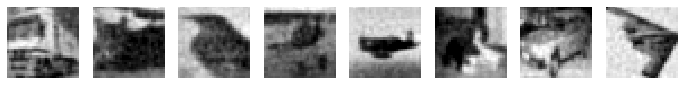

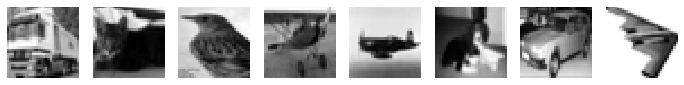

In [10]:
# Evaluation of eva1 model (shadow model)

eva1_imgs = [1, 9, 18, 35, 115, 128, 565, 605]

eva1_fig = plt.figure(figsize=(12, 12))
for i in range(len(eva1_imgs)):
  cur_img = eva1_fig.add_subplot(1, len(eva1_imgs), i+1)
  cur_img.axis('off')
  plt.imshow(shadow_img_fn(eva1_imgs[i], eva1_res).reshape(32, 32), cmap='gray')

eva2_fig = plt.figure(figsize=(12, 12))
for i in range(len(eva1_imgs)):
  cur_img = eva2_fig.add_subplot(1, len(eva1_imgs), i+1)
  cur_img.axis('off')
  plt.imshow(train_img_fn(eva1_imgs[i], gray(x_train)).reshape(32, 32), cmap='gray')

plt.show()

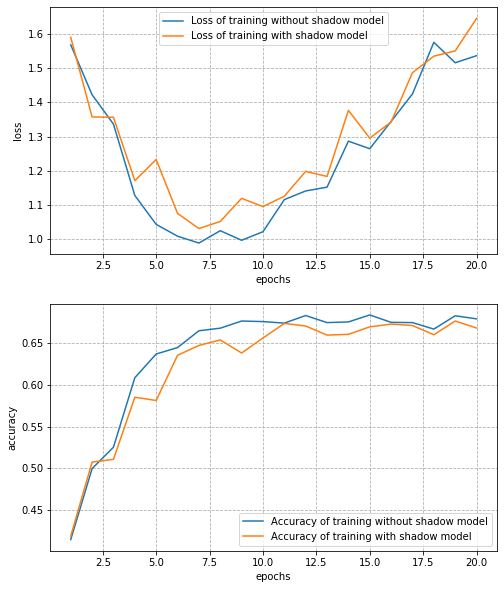

In [11]:
# Evaluation of side-effects on original model from shadow model

plot_x_epochs = [ (epoch+1) for epoch in range(res_epochs)]
eva3_stat_figure = plt.figure(figsize=(8,10))

# Plot for epoch-loss from training the clean model and the model involving shadow model
eva3_res_loss_plot = eva3_stat_figure.add_subplot(2, 1, 1)
eva3_res_loss_plot.grid(linestyle='--')
eva3_res_loss_plot.set_xlabel('epochs')
eva3_res_loss_plot.set_ylabel('loss')

eva3_res_cln_loss = [ res_cln_model_log[i]['loss'] for i in res_cln_model_log]
eva3_res_it_loss = [ res_it_model_log[i]['loss'] for i in res_it_model_log]
eva3_res_loss_plot.plot(plot_x_epochs, eva3_res_cln_loss, label='Loss of training without shadow model')
eva3_res_loss_plot.plot(plot_x_epochs, eva3_res_it_loss, label='Loss of training with shadow model')
eva3_res_loss_plot.legend()

# Plot for epoch-acc from training the clean model and the model involving shadow model
eva3_res_acc_plot = eva3_stat_figure.add_subplot(2, 1, 2)
eva3_res_acc_plot.grid(linestyle='--')
eva3_res_acc_plot.set_xlabel('epochs')
eva3_res_acc_plot.set_ylabel('accuracy')

eva3_res_cln_acc = [ res_cln_model_log[i]['acc'] for i in res_cln_model_log]
eva3_res_it_acc = [ res_it_model_log[i]['acc'] for i in res_it_model_log]
eva3_res_acc_plot.plot(plot_x_epochs, eva3_res_cln_acc, label='Accuracy of training without shadow model')
eva3_res_acc_plot.plot(plot_x_epochs, eva3_res_it_acc, label='Accuracy of training with shadow model')
eva3_res_acc_plot.legend()


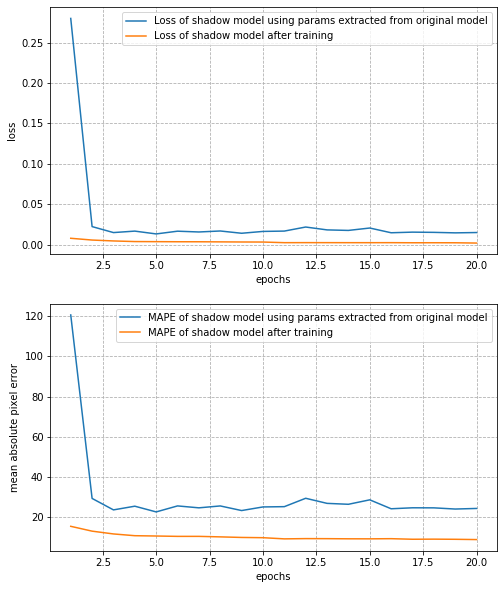

In [12]:
# Evaluation of side-effects on shadow model

plot_x_epochs = [ (epoch+1) for epoch in range(res_epochs)]
eva4_stat_figure = plt.figure(figsize=(8,10))

# Plot for epoch-loss
eva4_shadow_loss_plot = eva4_stat_figure.add_subplot(2, 1, 1)
eva4_shadow_loss_plot.grid(linestyle='--')
eva4_shadow_loss_plot.set_xlabel('epochs')
eva4_shadow_loss_plot.set_ylabel('loss')

eva4_shadow_pre_loss = [ shadow_model_pre_log[i]['loss'] for i in shadow_model_pre_log]
eva4_shadow_post_loss = [ shadow_model_log[i]['loss'] for i in shadow_model_log]
eva4_shadow_loss_plot.plot(plot_x_epochs, eva4_shadow_pre_loss, label='Loss of shadow model using params extracted from original model')
eva4_shadow_loss_plot.plot(plot_x_epochs, eva4_shadow_post_loss, label='Loss of shadow model after training')
eva4_shadow_loss_plot.legend()

# Plot for epoch-mape
eva4_shadow_mape_plot = eva4_stat_figure.add_subplot(2, 1, 2)
eva4_shadow_mape_plot.grid(linestyle='--')
eva4_shadow_mape_plot.set_xlabel('epochs')
eva4_shadow_mape_plot.set_ylabel('mean absolute pixel error')

eva4_shadow_pre_mape = [ shadow_model_pre_log[i]['mape'] for i in shadow_model_pre_log]
eva4_shadow_post_mape = [ shadow_model_log[i]['mape'] for i in shadow_model_log]
eva4_shadow_mape_plot.plot(plot_x_epochs, eva4_shadow_pre_mape, label='MAPE of shadow model using params extracted from original model')
eva4_shadow_mape_plot.plot(plot_x_epochs, eva4_shadow_post_mape, label='MAPE of shadow model after training')
eva4_shadow_mape_plot.legend()